# Transfert de style avec Pytorch

## Début
### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
import torchvision
from torchsummary import summary

from IPython.display import clear_output

from torchvision.utils import save_image

import copy

import numpy as np

C:\Users\louis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### CPU/GPU

Si le gpu est disponible nous allons l'utiliser, sinon on entraine sur cpu avec des images de taille moindre

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

"""
Device configuration
"""
torch.set_default_device(device)
print(device)

im_size = 256

cpu


## Import des images depuis le web

In [3]:
import requests
from PIL import Image
from io import BytesIO

# Remplacez cette URL par l'URL de l'image que vous souhaitez importer
style_url = "https://i.etsystatic.com/20564088/r/il/9233c1/1930578160/il_fullxfull.1930578160_63fk.jpg"
content_url = "https://www.lenouveleconomiste.fr/wp-content/uploads/2012/12/1642_VDH-GE-Soubeyran-Mines.jpg"

# Téléchargez l'image depuis l'URL
response_style = requests.get(style_url)
response_content = requests.get(content_url)

# Vérifiez que la requête a réussi
if response_style.status_code == 200:
    # L'image est correctement téléchargée
    image_data = response_style.content

    # Utilisez PIL pour ouvrir l'image depuis les données téléchargées
    image = Image.open(BytesIO(image_data))

    # Affichez l'image si nécessaire
    image.save("style.jpg")
else:
    print("Échec du téléchargement de l'image. Code de statut :", response_style.status_code)

if response_content.status_code == 200:
    # L'image est correctement téléchargée
    image_data = response_content.content

    # Utilisez PIL pour ouvrir l'image depuis les données téléchargées
    image = Image.open(BytesIO(image_data))

    # Affichez l'image si nécessaire
    image.save("contenu.jpg")
else:
    print("Échec du téléchargement de l'image. Code de statut :", response_content.status_code)

## Traitement des images
### Import des images
Import des images de la bonne taille et mise au format `(1, im_size, im_size, n_chanels)` \
Conversion des images en tensor Pytorch avec le bon device.\
Les images de contenu et de style doivent avoir la même taille.\



In [4]:
def import_and_process_image(image_name):
    img= Image.open(image_name)
    transform  = transforms.Compose([transforms.Resize(size=(im_size,im_size)), transforms.ToTensor()])
    img_tensor = transform(img)
    img_tensor = torch.unsqueeze(img_tensor,0)
    return img_tensor.to(device)
    

style_img = import_and_process_image("style.jpg")
content_img = import_and_process_image("contenu.jpg")

print(style_img.size(),content_img.size())
assert style_img.size() == content_img.size()

print(style_img.size())
print(content_img.size())

torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


### Affichage des images

Conversion en image PIL puis affichage

[[[0.1953125  0.23828125 0.31640625]
  [0.2109375  0.24609375 0.3203125 ]
  [0.19921875 0.22265625 0.28515625]
  ...
  [0.22265625 0.23828125 0.34375   ]
  [0.203125   0.20703125 0.29296875]
  [0.20703125 0.19921875 0.27734375]]

 [[0.2109375  0.23046875 0.33203125]
  [0.19921875 0.21484375 0.3125    ]
  [0.20703125 0.21875    0.30859375]
  ...
  [0.25390625 0.2734375  0.37890625]
  [0.21484375 0.22265625 0.30859375]
  [0.21484375 0.21484375 0.29296875]]

 [[0.19140625 0.19140625 0.30078125]
  [0.20703125 0.20703125 0.31640625]
  [0.2109375  0.20703125 0.3203125 ]
  ...
  [0.29296875 0.32421875 0.43359375]
  [0.265625   0.28125    0.37890625]
  [0.25       0.265625   0.3515625 ]]

 ...

 [[0.1328125  0.109375   0.0703125 ]
  [0.14453125 0.1171875  0.078125  ]
  [0.18359375 0.15625    0.1171875 ]
  ...
  [0.18359375 0.20703125 0.140625  ]
  [0.1953125  0.20703125 0.140625  ]
  [0.2109375  0.22265625 0.15234375]]

 [[0.12890625 0.10546875 0.078125  ]
  [0.14453125 0.12890625 0.08984375]


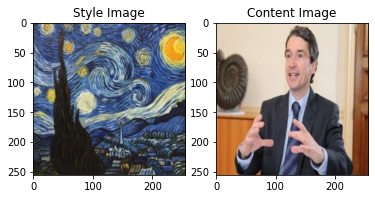

In [5]:
def imshow(tensor, title):
    image = torch.reshape(tensor,(3,im_size,im_size))
    img_draw = transforms.ToPILImage()(image)
    plt.imshow(img_draw)
    plt.title(title)
    print(np.array(img_draw)/256)
    return img_draw



plt.figure()
plt.subplot(1, 2, 1)
imshow(style_img, title='Style Image')

plt.subplot(1, 2, 2)
imshow(content_img, title='Content Image')

plt.show()

## Loss
### Contenu

Calculer la loss de contenu avec la MSE à partir des features données

In [12]:
def calc_content_loss(gen_feat, orig_feat):
    '''
    Entrée : 2 tenseurs de features (sorties de VGG19)
    Fonction qui calcule la loss de contenu
    '''
    sq_delta = (gen_feat-orig_feat)**2
    loss = 1/gen_feat.numel()*torch.sum(sq_delta)
    return loss

### Style

Calculer la loss de style avec la MSE sur les matrices de gramm \
On normalise le résultat à la fin.

In [13]:
def gram_matrix(input):
    '''
    Entrée : un tenseur (a, b, c, d)
    Sortie : un tenseur (a*b, a*b)
    '''
    (a,b,c,d) = input.size()
    resized = input.view(a*b,c*d)
    gram = torch.matmul(resized, resized.t())
    return gram/(c*d)

In [14]:
def calc_style_loss(gen,style):
    '''
    Entrée : 2 tenseurs de features (sorties de VGG19)
    Fonction qui calcule la loss de style
    '''
    gram_gen = gram_matrix(gen)
    gram_style = gram_matrix(style)
    return calc_content_loss(gram_gen,gram_style)

## Loss totale

In [15]:
#alpha and beta les poids de la loss de contenu et de style
alpha = 1
beta = 1e12

def calculate_loss(gen_features, orig_feautes, style_featues):
    '''
    Entrée : 3 listes de tenseurs de features (sorties de VGG19)
    Fonction qui calcule la loss totale
    ''' 
    loss_content = calc_content_loss(gen_features,orig_feautes)
    loss_style = calc_style_loss(gen_features, style_featues)
    return alpha/beta * loss_content + loss_style 


### Import de vgg19

In [16]:
"""
A completer pour l'import de VGG19
"""
import torchvision

vgg19=torchvision.models.vgg19(torchvision.models.VGG19_Weights.IMAGENET1K_V1).to(device).eval()
print(vgg19)

# models.vgg19()
# vgg19=models.vgg19(pretrained=True)

Features=vgg19.features[:29].to(device).eval()

C:\Users\louis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## Entrainement :

In [20]:
import wandb

wandb.login()

run = wandb.init(
    # Nom du Projet
    project="projet transfert de style",
    # Sauvegarde des hyperparamètres
    config={
        "learning_rate": 0.005,
        "epochs": 50,
    })

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


loss,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.47773


In [21]:
epoch=50
lr=0.005
new_img = content_img.detach().clone().requires_grad_(True)

optimizer=torch.optim.Adam([new_img], lr=lr) # A completer

loss_values = [] # Pour plot la loss
style_feature=Features(style_img)
cont_feature=Features(content_img)
print(style_feature.size())
print(cont_feature.size())
for i in range(epoch):
  total=0.
  optimizer.zero_grad()   ## réinitialiser les gradients
  gen_features= Features(new_img)  ## forward pass
  loss = calculate_loss(gen_features, cont_feature, style_feature)
  loss.backward(retain_graph=True)  ## backpropagation pass à travers le réseau
  optimizer.step() ## mise à jour des paramètres du réseau ( w = w -lr * w.grad) équivalent à une itération du SGD
  loss_values.append(float(loss)) ## calcul de la loss sur tous les exemples à chaque époque
  wandb.log({"loss": loss})
new_img=torch.clamp(new_img,0,1)
print(new_img)

torch.Size([1, 512, 16, 16])
torch.Size([1, 512, 16, 16])
tensor([[[[0.8322, 0.8268, 0.9614,  ..., 0.7933, 0.7187, 0.7261],
          [0.8154, 0.9542, 0.9736,  ..., 0.7438, 0.7206, 0.6762],
          [0.9766, 0.9979, 1.0000,  ..., 0.8455, 0.7983, 0.7861],
          ...,
          [0.8449, 0.8523, 0.8183,  ..., 0.4775, 0.5017, 0.5368],
          [0.7553, 0.7958, 0.8278,  ..., 0.3197, 0.3591, 0.3779],
          [0.7344, 0.7601, 0.8338,  ..., 0.3120, 0.3659, 0.4067]],

         [[0.7866, 0.7896, 0.9095,  ..., 0.7445, 0.6443, 0.5987],
          [0.8667, 0.9210, 0.8811,  ..., 0.7635, 0.6158, 0.5325],
          [0.9188, 0.9368, 0.8948,  ..., 0.7824, 0.6875, 0.5831],
          ...,
          [0.4880, 0.4791, 0.4678,  ..., 0.2288, 0.2486, 0.2653],
          [0.4502, 0.4152, 0.4706,  ..., 0.1510, 0.1003, 0.1149],
          [0.3706, 0.3267, 0.4692,  ..., 0.1389, 0.1097, 0.1579]],

         [[0.8179, 0.8041, 0.8113,  ..., 0.7905, 0.6993, 0.6920],
          [0.8411, 0.8219, 0.7705,  ..., 0.8354, 0

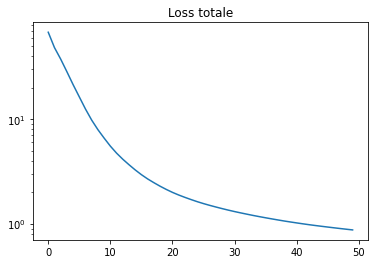

In [22]:
y = np.array(loss_values)
x = np.arange(len(loss_values))
plt.plot(x, y)
plt.yscale("log")
plt.title("Loss totale")
plt.show()

# Affichage des résultats

[[[0.828125   0.78125    0.8125    ]
  [0.8203125  0.78515625 0.80078125]
  [0.95703125 0.90234375 0.8046875 ]
  ...
  [0.7890625  0.73828125 0.78515625]
  [0.71484375 0.640625   0.6953125 ]
  [0.72265625 0.59375    0.6875    ]]

 [[0.80859375 0.859375   0.8359375 ]
  [0.94921875 0.9140625  0.81640625]
  [0.96875    0.875      0.765625  ]
  ...
  [0.73828125 0.7578125  0.83203125]
  [0.71484375 0.61328125 0.7421875 ]
  [0.671875   0.52734375 0.578125  ]]

 [[0.97265625 0.9140625  0.8203125 ]
  [0.9921875  0.9296875  0.8515625 ]
  [0.99609375 0.890625   0.62109375]
  ...
  [0.83984375 0.77734375 0.71875   ]
  [0.79296875 0.68359375 0.67578125]
  [0.78125    0.578125   0.515625  ]]

 ...

 [[0.83984375 0.484375   0.203125  ]
  [0.84765625 0.4765625  0.1796875 ]
  [0.8125     0.46484375 0.14453125]
  ...
  [0.47265625 0.2265625  0.1171875 ]
  [0.49609375 0.24609375 0.125     ]
  [0.53125    0.26171875 0.109375  ]]

 [[0.75       0.4453125  0.16796875]
  [0.7890625  0.41015625 0.1171875 ]


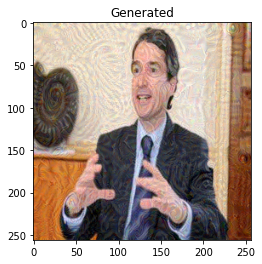

In [24]:
# plt.subplot(2,2,1)
# imshow(style_img, title="Style")

# plt.plot()
imshow(new_img, title="Generated")

# plt.subplot(2,2,2)
# imshow(content_img, title="Content")
plt.show()